In [1]:
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.style.use('ggplot')

from libs.utils import montage
from libs import gif

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
'''
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) 
X_test = X_test.astype(np.float32).reshape(-1, 28*28) 
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
'''
from libs.datasets import MNIST
ds = MNIST()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
ds.X.shape

(70000, 784)

In [4]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

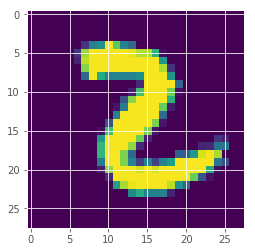

In [5]:
plt.imshow(ds.X[1].reshape((28,28)))

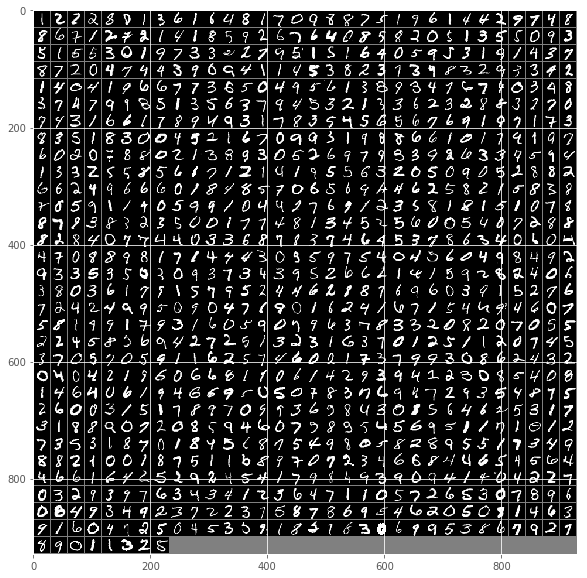

In [6]:
imgs = ds.X[:1000].reshape((-1,28,28))
plt.figure(figsize=(10,10))
plt.imshow(montage(imgs), cmap='gray')

In [7]:
mean_img = np.mean(ds.X, axis = 0)
std_img = np.std(ds.X, axis=0)

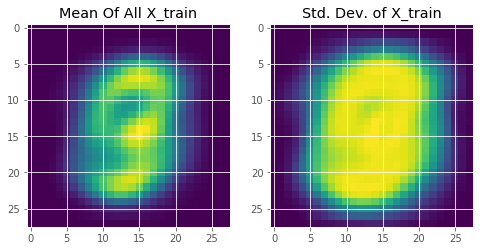

In [8]:
fig=plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 2, 1) #add_subplot(rows, cols, increment)
ax1.title.set_text('Mean Of All X_train')
ax1 = plt.imshow(mean_img.reshape((28,28)))

ax2 = fig.add_subplot(1, 2, 2)
ax2.title.set_text('Std. Dev. of X_train')
plt.imshow(std_img.reshape((28,28)))

plt.show()

In [9]:
dimensions = [512,256,128,64]

In [10]:
n_features = ds.X.shape[1] # no of features
X = tf.placeholder(tf.float32, shape=[None, n_features])
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

In [11]:
n_filters = [16,16,16]
filters_size = [4,4,4]

In [12]:
# let's first copy our X placeholder to the name current_input
current_input = X_tensor
n_input = 1

# Keep every matrix we create so let's create a list to hold them all
Ws = []
shapes =[]

# Create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):

    # just like in the last session,
    # Use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):

        shapes.append(current_input.get_shape().as_list())
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable( name='W', shape=[filters_size[layer_i], 
                                              filters_size[layer_i], 
                                              n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W, strides=[1, 2, 2, 1], padding='SAME')

        # relu activation function on its output
        current_input = tf.nn.relu(h)

        # Store the weight matrix so we can build the decoder.
        Ws.append(W)

        # Replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

In [13]:
print(current_input.shape)

(?, 4, 4, 16)


In [14]:
Ws = Ws[::-1]
shapes = shapes[::-1]
n_filters = n_filters[::-1]
# append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]
print("Ws: ", Ws)
print("shapes: ", n_filters)
print("n_filters: ", n_filters)

Ws:  [<tf.Variable 'encoder/layer/2/W:0' shape=(4, 4, 16, 16) dtype=float32_ref>, <tf.Variable 'encoder/layer/1/W:0' shape=(4, 4, 16, 16) dtype=float32_ref>, <tf.Variable 'encoder/layer/0/W:0' shape=(4, 4, 1, 16) dtype=float32_ref>]
shapes:  [16, 16, 1]
n_filters:  [16, 16, 1]


In [15]:
for layer_i, shape in enumerate(shapes):
    # Use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        h = tf.nn.conv2d_transpose(current_input, W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME')

        # relu activation function on its output
        current_input = tf.nn.relu(h)

In [16]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

In [17]:
cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


In [18]:
cost = tf.reduce_mean(cost)

In [19]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [21]:
batch_size = 100
n_epochs = 50
examples = ds.X[:100]
imgs = []

0 0.026563076
1 0.027099214
2 0.02499006
3 0.025070515
4 0.024493748
5 0.024743177
6 0.023765512
7 0.024827957
8 0.02424517
9 0.024472756
10 0.022868473
11 0.022913808
12 0.024544485
13 0.024202835
14 0.02431203
15 0.024293354
16 0.024198549
17 0.024296965
18 0.024251914
19 0.024461769
20 0.023489749
21 0.024564307
22 0.023521835
23 0.02356628
24 0.023595681
25 0.023352554
26 0.024099026
27 0.02462369
28 0.02354244
29 0.02420859
30 0.024493542
31 0.02376194
32 0.023298057
33 0.023937041
34 0.023320533
35 0.024188459
36 0.022297066
37 0.023526745
38 0.024577312
39 0.023262665
40 0.024192927
41 0.023743048
42 0.024370953
43 0.023826474
44 0.023751177
45 0.023293003
46 0.023330877
47 0.023223264
48 0.022636749
49 0.02342456


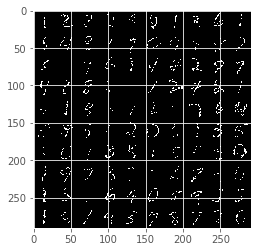

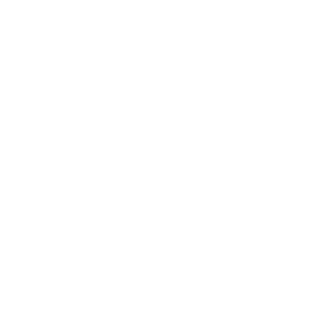

In [22]:
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [23]:
import IPython.display as ipyd
ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
           height=500, width=500)